In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from dataset import getAllDataPath, CustomImageDataset, show_image
from unet import UNet
from ResUnet import ResUnet
from AttentionUnet import AttUnet
from loss import DiceLoss, FocalLoss

In [3]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
#     A.Rotate((-30, 30), interpolation=0), 
#     A.RandomContrast(limit=0.2, p=1), 

    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

In [5]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_imgOnly_data = getAllDataPath(root, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_imgOnly_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=True)
# CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
# CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (123, 2)
MRI_data test (31, 2)
MRI_imgOnly_data train (309,)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([45667, 10436,  4899,  2220,  1024,   571,   454,   178,    56,
          31]), array([0.        , 0.09990968, 0.19981936, 0.29972905, 0.3996387 ,
       0.4995484 , 0.5994581 , 0.69936776, 0.7992774 , 0.89918715,
       0.9990968 ], dtype=float32)) tensor([0.])


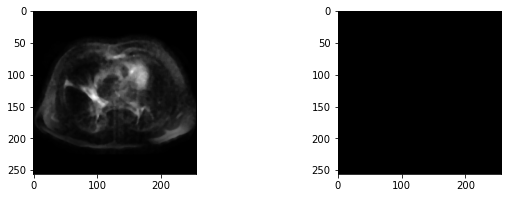

In [6]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
    
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())
        break
    break

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.ops import sigmoid_focal_loss

class unetModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.encoder = model
#         self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        outputs = self.encoder(x)

        loss = sigmoid_focal_loss(outputs, y, reduction='sum')
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x):
        return self.encoder(x)

In [8]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: 
- https://pytorch.org/docs/stable/optim.html 
- Road Extraction by Deep Residual U-Net, 2017
- U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
- Attention U-Net: Learning Where to Look for the Pancreas, 2018
'''
 
# model = UNet
model = ResUnet # suggest: only use it for single channel outputs, Sigmoid activation, Dice loss or focal loss
# model = AttUnet # better ResUnet 
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-1)

In [18]:
'''
torch-lightning
'''
save_root = './data/save_weights/'
model = unetModel(model)

# train model
try:
    checkpoint_callback = ModelCheckpoint(monitor='train_loss',
                dirpath=save_root,
                filename='{epoch}_{val_loss:.2f}_model',
                save_top_k = 3,
                mode = 'min',
                save_weights_only = True,
                )
    
    trainer = pl.Trainer(devices=2, accelerator="gpu", strategy='ddp', callbacks=[checkpoint_callback], max_epochs=150)
    trainer.fit(model=model, train_dataloaders=dataloader_train)
except:
    print('strategy=ddp or dp is not compatible with an interactive environmen(ex: Jupyter Notebook)')

strategy=ddp or dp is not compatible with an interactive environmen(ex: Jupyter Notebook)


## testing

In [27]:
# 'from normal pytorch'
# # model = ResUnet
# # model = model(HEIGHT, in_ch=1, out_ch=3, activation=None).to(device)
# # save_root = './data/save_weights/'
# # filepath = f'{save_root}E299_model.bin'
# # model.load_state_dict(torch.load(filepath)) 

# 'pytorch-lightning'
# model = ResUnet
# model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)
# model = unetModel(model)
# checkpoint = torch.load(save_root+'epoch=99_train_loss=775.5070_model.ckpt')
# model.load_state_dict(checkpoint['state_dict'])


In [28]:
# '''
# abs: testing model
# ---
# '''

# for i, data in enumerate(dataloader_test, 1):
#     image, mask = data
#     print(len(image), image.shape, mask.shape)
#     with torch.no_grad():
#         image = image.to(device)
#         mask = mask.to(device)
#         outputs = model(image)

#     'single channel outputs'
#     threshold = 0
#     outputs[outputs>=threshold] = 1.
#     outputs[outputs!=1] = 0.

#     'multi channel outputs'
# #     outputs = F.softmax(outputs)
# #     outputs = torch.argmax(outputs, dim=1) # with pseudo label
# #     outputs = (torch.argmax(outputs, dim=1)==2).int() # only liver segmentation
    
#     loss = DiceLoss()(outputs, mask)
#     print(loss)
#     img_process = lambda image:image.squeeze(1).cpu().numpy()
#     mask_process = lambda mask:mask.squeeze(1).cpu().numpy()

#     for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
#         show_image(x, m, outputs)
# #         break
            
#     del outputs, image, mask

In [1]:
import os
from IPython import get_ipython 
try:
    if get_ipython().__class__.__name__=='ZMQInteractiveShell':
        os.system('jupyter nbconvert train_unet_lightning.ipynb --to python')
except NameError:
    pass

[NbConvertApp] Converting notebook train_unet_lightning.ipynb to python
[NbConvertApp] Writing 6692 bytes to train_unet_lightning.py
